# UNet for infrared data segmentation

Based on:
https://github.com/overshiki/unet-pytorch/blob/master/utils.py

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models

import os
import torch.optim as optim
import torch.nn.functional as F
import scipy
from skimage.transform import rotate  # Corrected this line
from os.path import join
from struct import unpack
import time

import codecs

# Uncomment and adjust this block if you need to list the files in the input directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Set Hyper Parameters

In [2]:
batch_size = 1
epochs = 30
channel_num=1810 # each infrared video has 1810 frames
crop_h = 128
crop_w = 128
learning_rate = 0.0001

# CPU or GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')


if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
    use_cuda = True
else:
    use_cuda = False
kwargs = {'num_workers': 0,
          'pin_memory': True} if use_cuda else {}

Device is cuda
CUDA device <torch.cuda.device object at 0x7e2bc10ff5e0>
Number of devices: 2
Device name: Tesla T4


# read image from image path

In [4]:
from scipy import io
def make_dataset(img_filename_list, mask_filename_list, root):
    # build the dataset
    imgs = []
    masks = []
    
    for img_filename in img_filename_list:
        print(img_filename)
        mat_data = io.loadmat(join(root, img_filename))
        p = np.float32(mat_data["imageArray"])
        imgs.append(p)
    return imgs, mask_filename_list

# functions for image cropping and data augmentation

In [5]:
def getCroprange(im_w, im_h, h, w):
    # getting croprange
    min_w = random.randint(0, im_w - w)
    min_h = random.randint(0, im_h - h)
    return min_w, min_h


class crop_clip():
    # crop function
    # crop_clip.image for original training data,crop_clip.mask for corresponding mask(ground truth)
    def __init__(self, clip, h, w, min_h, min_w):
        self.clip = clip
        self.h = h
        self.w = w
        self.min_h = min_h
        self.min_w = min_w
        self.clip = clip

    def image(self):
        cropped = self.clip[self.min_h:self.min_h + self.h, self.min_w:self.min_w + self.w, :]
        return cropped

    def mask(self):
        cropped = self.clip.crop((self.min_w, self.min_h, self.min_w + self.w, self.min_h + self.h))
        return cropped


class RandomRotation():
    # rotation
    def __init__(self, clip, angle):
        self.clip = clip
        self.angle = angle

    def image(self):
        h, w, c = self.clip.shape
        rotated = np.zeros((h, w, c), dtype=np.float32)
        for i in range(c):
            # clip[:,:,i] = scipy.misc.imrotate(clip[:,:,i], angle)  #does not work..
            p = Image.fromarray(self.clip[:, :, i])
            p = p.rotate(self.angle)
            rotated[:, :, i] = np.array(p)
        return rotated

    def mask(self):
        rotated = self.clip.rotate(self.angle)
        return rotated

## Dataset


In [6]:
import random
class Data_set():
    def __init__(self, imgs, masks, root, crop_h, crop_w, ctype):
        self.imgs = imgs
        self.masks = masks
        self.type = ctype
        self.root = root
        self.crop_w = crop_w
        self.crop_h = crop_h
        random.seed(1)
        self.random_func = random
    def __len__(self):
        return len(self.imgs)

    def normalize(self, img):
        # input is torch tensor
        eps = 1e-10
        mean_value = torch.mean(img)
        std_value = torch.std(img)
        normed_img = (img - mean_value) / max(eps, std_value)
        return normed_img

    def transform(self, imgs, masks):
        image = imgs[:,:,:]
        mask = masks

        # rotate
        angle = self.random_func.uniform(0, 90)
        random_rotation_image = RandomRotation(image, angle)
        roteted_image = random_rotation_image.image()
        random_rotation_mask = RandomRotation(mask, angle)
        roteted_mask = random_rotation_mask.mask()

        ##crop
        im_h, im_w, im_c = imgs.shape
        min_w = self.random_func.randint(0, im_w - self.crop_w)
        min_h = self.random_func.randint(0, im_h - self.crop_h)
        crop_clip_image_obj = crop_clip(roteted_image, self.crop_h, self.crop_w, min_h, min_w)
        crop_clip_mask_obj = crop_clip(roteted_mask, self.crop_h, self.crop_w, min_h, min_w)
        image = crop_clip_image_obj.image()  ##normal case
        im_h1, im_w1, im_c1 = image.shape
        mask = crop_clip_mask_obj.mask()

        left_right_flip_rand_num =  self.random_func.random()
        if left_right_flip_rand_num > 0.5:
            image = np.fliplr(image)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        up_down_flip_rand_num =  self.random_func.random()
        if up_down_flip_rand_num > 0.5:
            image = np.flipud(image)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        image = torch.from_numpy(image.copy())
        image = image.permute(2, 0, 1)
        image = self.normalize(image)
        mask = transforms.ToTensor()(mask)
        #print('max mask:')
        #print(torch.max(mask))
        return image, mask


    def __getitem__(self, index):
        img_x, maskpath = self.imgs[index], self.masks[index]
        mask_x = Image.open(join(self.root, maskpath))
        mask_x_np = np.array(mask_x)
        import skimage.io as im
        mask_x_sk = im.imread(join(self.root, maskpath))
        img_x, mask_x = self.transform(img_x, mask_x)
        return img_x, mask_x

## Instantiate the Dataset and DataLoader


In [7]:
def read_text_file_list(filepath):
    content = []
    with codecs.open(filepath, encoding='utf-8') as f:
        for line in f:
            content.append(line.strip())
    return content

data_splitting_folder = "/kaggle/input"
root = data_splitting_folder
train_datalist_filename = "train_data.txt"
val_datalist_filename = "val_data.txt"
train_labellist_filename = "train_label.txt"
val_labellist_filename = "val_label.txt"

train_img_file_list = read_text_file_list(join(data_splitting_folder, train_datalist_filename))
train_gt_mask_file_list = read_text_file_list(join(data_splitting_folder, train_labellist_filename))
val_img_file_list = read_text_file_list(join(data_splitting_folder, val_datalist_filename))
val_gt_mask_file_list = read_text_file_list(join(data_splitting_folder, val_labellist_filename))

train_imgs, train_masks = make_dataset(train_img_file_list, train_gt_mask_file_list, data_splitting_folder)
train_dataset = Data_set(train_imgs, train_masks, data_splitting_folder, crop_h, crop_w, 'train')
train_data_loader = DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               **kwargs)
val_imgs, val_masks = make_dataset(val_img_file_list, val_gt_mask_file_list, data_splitting_folder)
val_dataset = Data_set(val_imgs, val_masks, data_splitting_folder, crop_h, crop_w, 'validate')
val_data_loader = DataLoader(dataset=val_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)

Z_003.mat
Z_005.mat
Z_006.mat
Z_007.mat
Z_010.mat
Z_011.mat
Z_012.mat
Z_014.mat
Z_015.mat
Z_016.mat
Z_018.mat
Z_019.mat
Z_020.mat
Z_002.mat
Z_008.mat
Z_017.mat


## UNet Network

In [8]:
class one_step_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(one_step_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
            #nn.Conv2d(out_ch, out_ch, 3, padding=1),
            #nn.BatchNorm2d(out_ch),
            #nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        base_filter_num = 64
        self.conv_down_1 = one_step_conv(in_ch, base_filter_num)
        self.pool1 = nn.MaxPool2d(2)
        self.conv_down_2 = one_step_conv(base_filter_num, base_filter_num*2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv_down_3 = one_step_conv(base_filter_num*2, base_filter_num*4)
        self.pool3 = nn.MaxPool2d(2)
        self.conv_down_4 = one_step_conv(base_filter_num*4, base_filter_num*8)
        self.pool4 = nn.MaxPool2d(2)
        self.conv_bottom = one_step_conv(base_filter_num*8, base_filter_num*16)
        
        self.upsample_1 = nn.ConvTranspose2d(base_filter_num*16, base_filter_num*8, 2, stride=2)
        self.conv_up_1 = one_step_conv(base_filter_num*16, base_filter_num*8)
        self.upsample_2 = nn.ConvTranspose2d(base_filter_num*8, base_filter_num*4, 2, stride=2)
        self.conv_up_2 = one_step_conv(base_filter_num*8, base_filter_num*4)
        self.upsample_3 = nn.ConvTranspose2d(base_filter_num*4, base_filter_num*2, 2, stride=2)
        self.conv_up_3 = one_step_conv(base_filter_num*4, base_filter_num*2)
        self.upsample_4 = nn.ConvTranspose2d(base_filter_num*2, base_filter_num, 2, stride=2)
        self.conv_up_4 = one_step_conv(base_filter_num*2, base_filter_num)
        self.conv_out = nn.Conv2d(base_filter_num, out_ch, 1)

    def forward(self, x):
        ###down########
        down_1 = self.conv_down_1(x)
        pool_1 = self.pool1(down_1)
        down_2 = self.conv_down_2(pool_1)
        pool_2 = self.pool2(down_2)
        down_3 = self.conv_down_3(pool_2)
        pool_3 = self.pool3(down_3)
        down_4 = self.conv_down_4(pool_3)
        pool_4 = self.pool3(down_4)
        bottom = self.conv_bottom(pool_4)

        up_1 = self.upsample_1(bottom)
        merge1 = torch.cat([up_1, down_4], dim=1)
        up_1_out = self.conv_up_1(merge1)
        
        up_2 = self.upsample_2(up_1_out)
        merge2 = torch.cat([up_2, down_3], dim=1)
        up_2_out = self.conv_up_2(merge2)
        
        up_3 = self.upsample_3(up_2_out)
        merge3 = torch.cat([up_3, down_2], dim=1)
        up_3_out = self.conv_up_3(merge3)
        
        up_4 = self.upsample_4(up_3_out)
        merge4 = torch.cat([up_4, down_1], dim=1)
        up_3_out = self.conv_up_4(merge4)
        
        end_out = self.conv_out(up_3_out)
        out = nn.Sigmoid()(end_out)

        return out

## Network optimizer and loss function

In [9]:
model = Unet(in_ch=channel_num, out_ch=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = torch.nn.BCELoss()

# Validation funtion

In [10]:
import sklearn.metrics as metrics # for evaluation

def validate(model, loss_fn, dataloader, device):
    step = 0
    acc_sum = 0
    loss_sum = 0
    with torch.no_grad():
        for i, (vali_batch, vali_mask) in enumerate(dataloader):
            step += 1
            vali_batch, vali_mask = vali_batch.to(device), vali_mask.to(device, dtype=torch.long)
            vali_mask = vali_mask.float()
            prediction = model(vali_batch)
            prediction = torch.squeeze(prediction)
            vali_mask = torch.squeeze(vali_mask)
            val_loss = loss_fn(prediction, vali_mask)
            loss_sum += val_loss.data.item()

            threshold_using = 0.5 # for binarization
            binary = prediction >= threshold_using
            _accuracy = metrics.accuracy_score(vali_mask.cpu().view(-1).detach().numpy(), binary.cpu().view(-1).detach().numpy())    
            acc_sum += _accuracy

            
    loss = loss_sum / len(dataloader)
    acc = acc_sum / len(dataloader)

    return loss, acc 

## Train the model


Epoch 0 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 0, accuracy: 0.8340172400841346, loss: 0.612880683862246


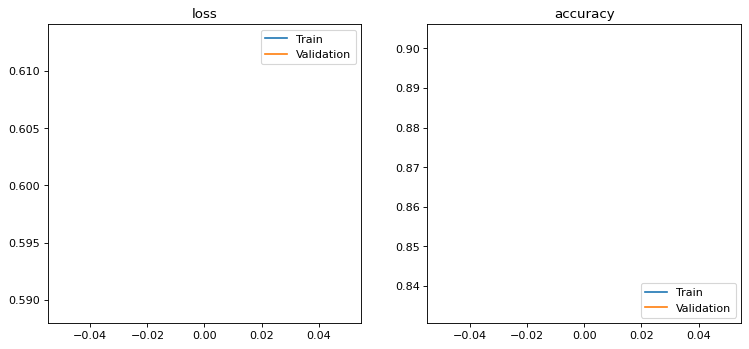

 min val_loss
inf
Epoch 1 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 1, accuracy: 0.9302837665264423, loss: 0.5350769758224487


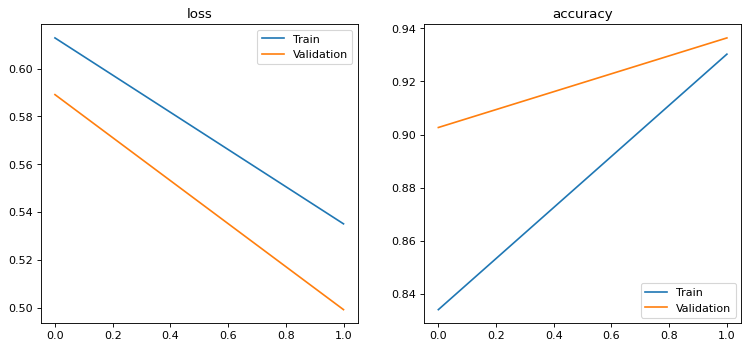

 min val_loss
0.589155375957489
Epoch 2 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 2, accuracy: 0.9454064002403846, loss: 0.4765560214336102


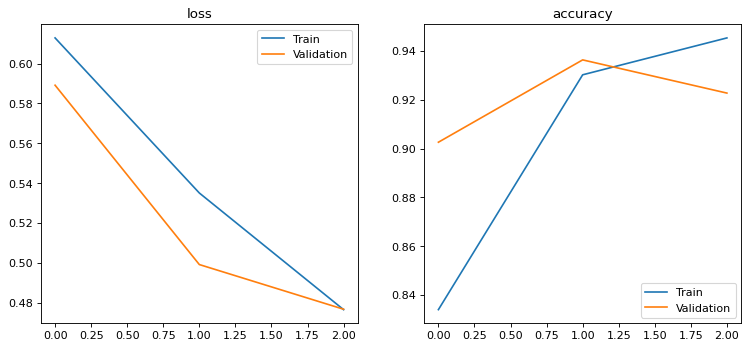

 min val_loss
0.49917415777842206
Epoch 3 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 3, accuracy: 0.9578998272235577, loss: 0.46768635282149684


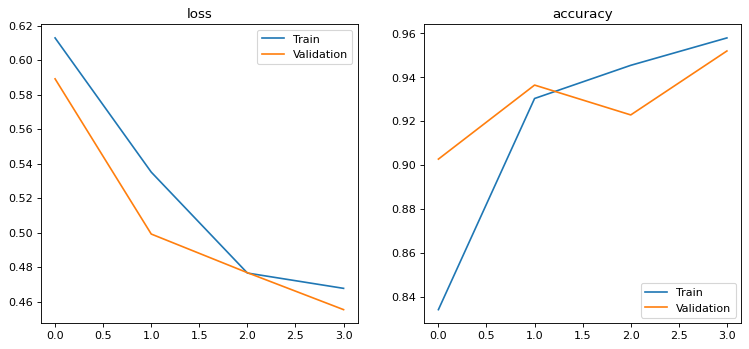

 min val_loss
0.47676587104797363
Epoch 4 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 4, accuracy: 0.9570453350360577, loss: 0.4176664994313167


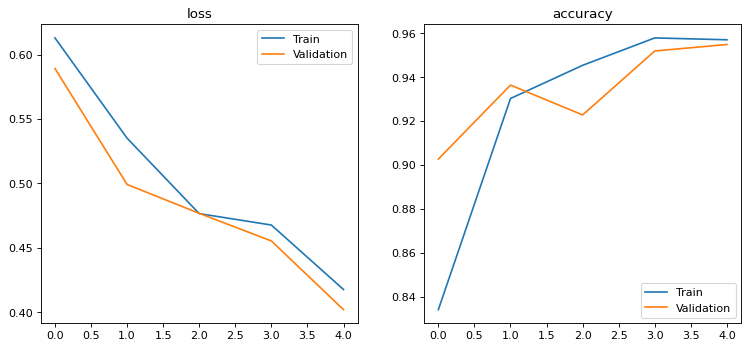

 min val_loss
0.4553459088007609
Epoch 5 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 5, accuracy: 0.9515193058894231, loss: 0.41137914244945234


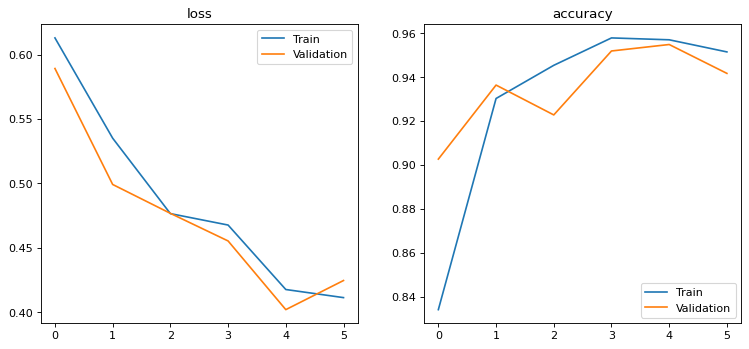

 min val_loss
0.40205148855845135
Epoch 6 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 6, accuracy: 0.9726515549879807, loss: 0.386004959161465


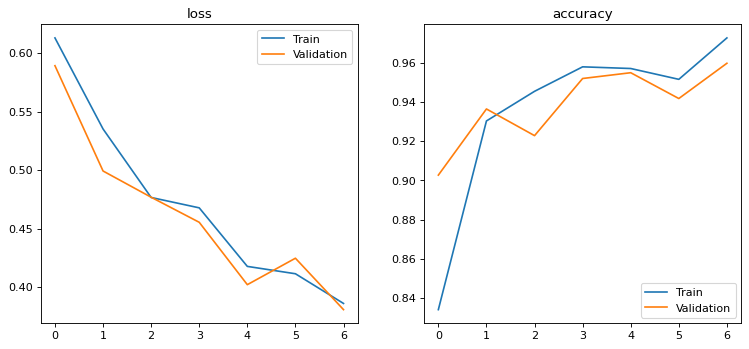

 min val_loss
0.40205148855845135
Epoch 7 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 7, accuracy: 0.96966552734375, loss: 0.36425206523675185


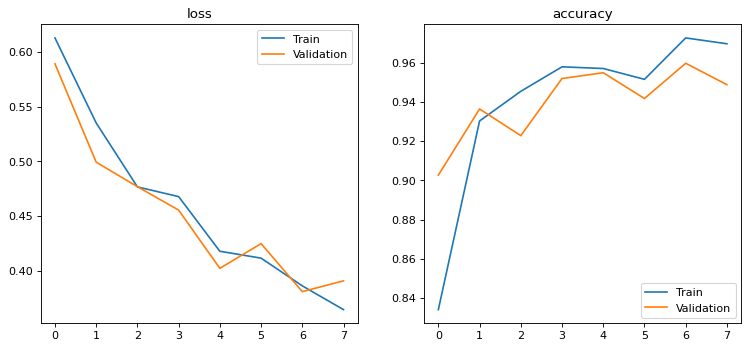

 min val_loss
0.3807186384995778
Epoch 8 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 8, accuracy: 0.9634258563701923, loss: 0.3484646998918973


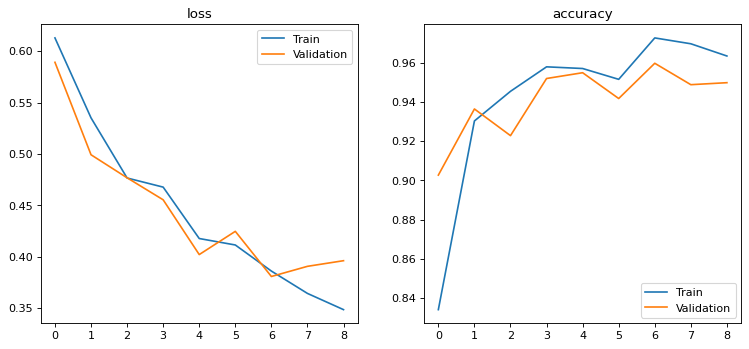

 min val_loss
0.3807186384995778
Epoch 9 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 9, accuracy: 0.9667640099158654, loss: 0.3578212192425361


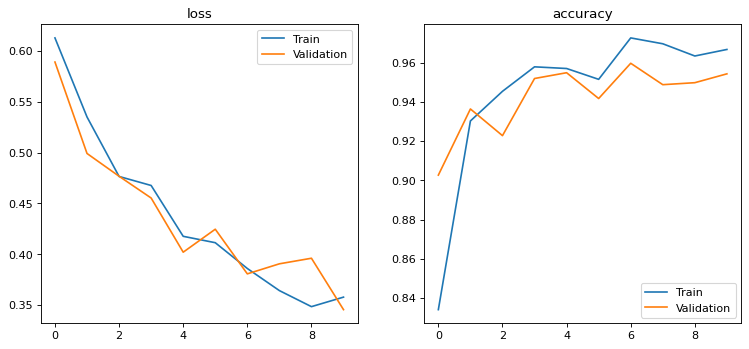

 min val_loss
0.3807186384995778
Epoch 10 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 10, accuracy: 0.9735342172475961, loss: 0.34172181211985075


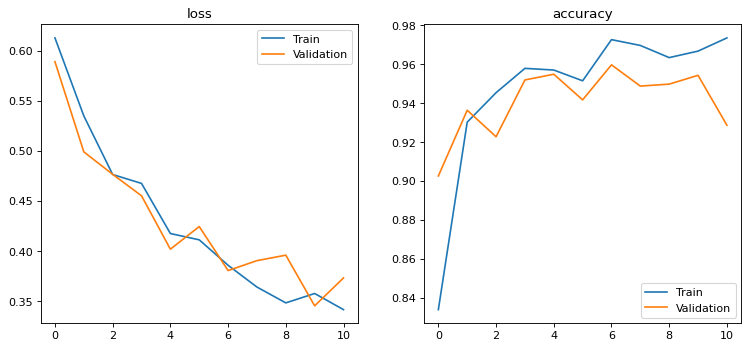

 min val_loss
0.34551748633384705
Epoch 11 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 11, accuracy: 0.9653085561899039, loss: 0.32540286504305327


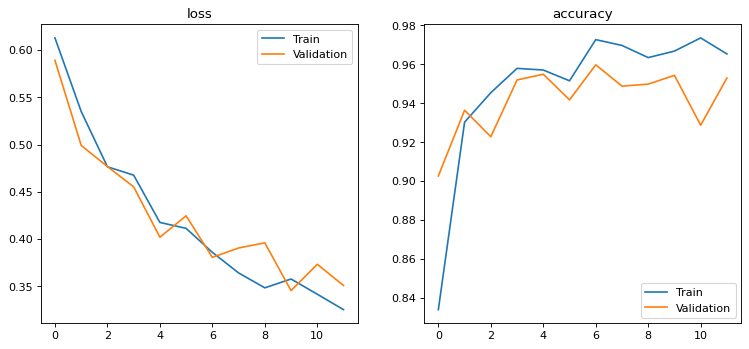

 min val_loss
0.34551748633384705
Epoch 12 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 12, accuracy: 0.9770226111778846, loss: 0.3207852840423584


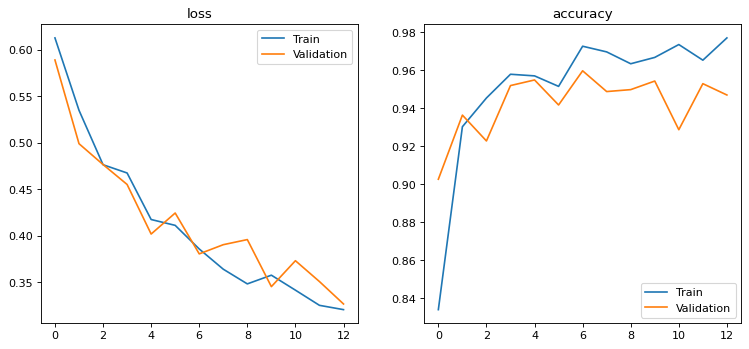

 min val_loss
0.34551748633384705
Epoch 13 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 13, accuracy: 0.9640315129206731, loss: 0.32241703455264753


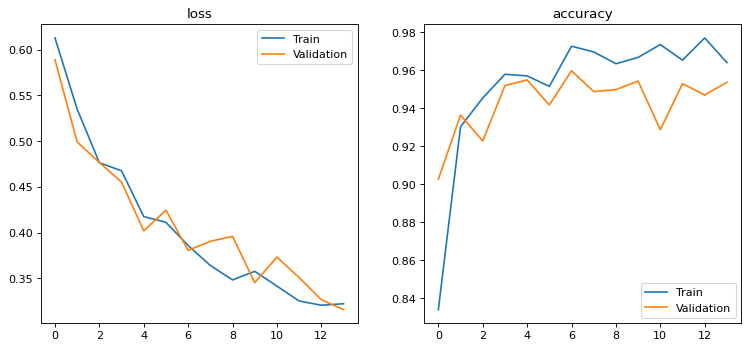

 min val_loss
0.3268658717473348
Epoch 14 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 14, accuracy: 0.9753746619591346, loss: 0.29669753404764027


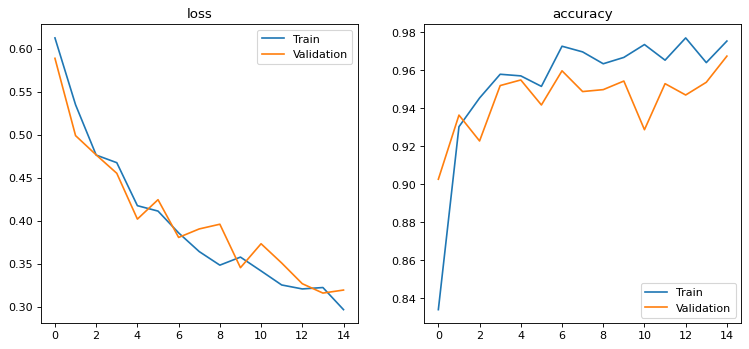

 min val_loss
0.31597041090329486
Epoch 15 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 15, accuracy: 0.9688485952524039, loss: 0.307766487965217


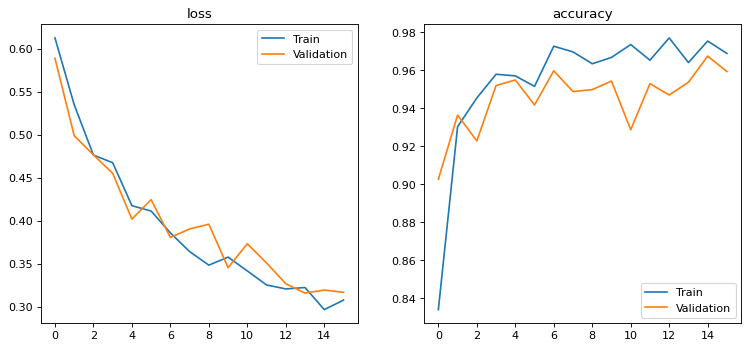

 min val_loss
0.31597041090329486
Epoch 16 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 16, accuracy: 0.9640362079326923, loss: 0.30092963117819566


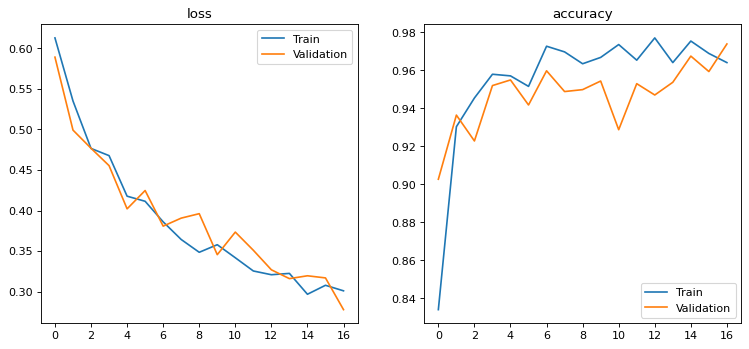

 min val_loss
0.31597041090329486
Epoch 17 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 17, accuracy: 0.9669189453125, loss: 0.2879242713634784


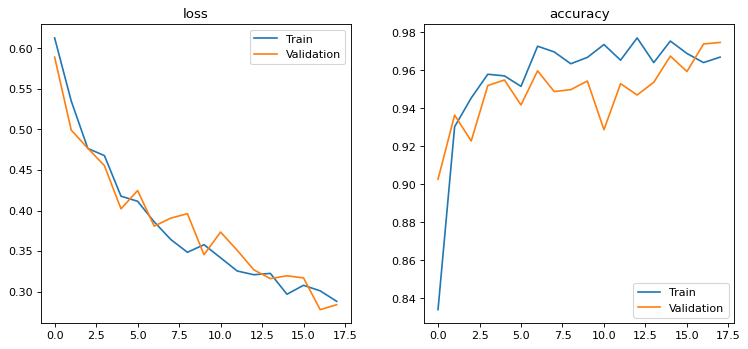

 min val_loss
0.2777263323465983
Epoch 18 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 18, accuracy: 0.9724214993990384, loss: 0.27669882201231444


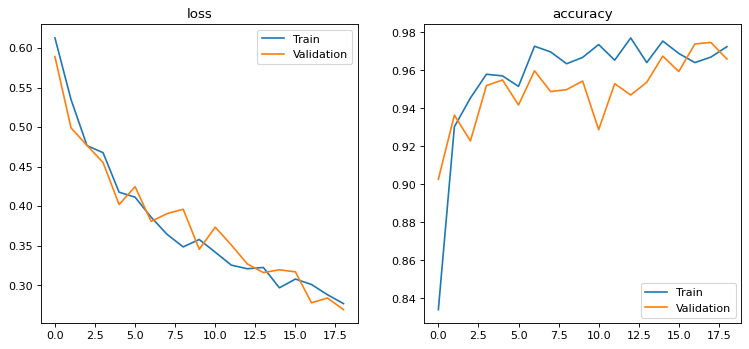

 min val_loss
0.2777263323465983
Epoch 19 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 19, accuracy: 0.971923828125, loss: 0.27032728837086606


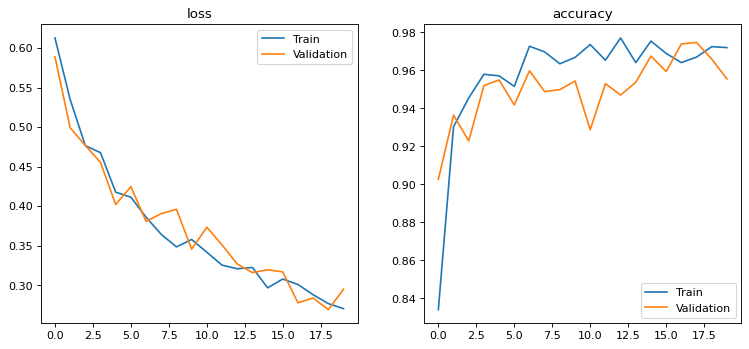

 min val_loss
0.26907260219256085
Epoch 20 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 20, accuracy: 0.9691068209134616, loss: 0.26795778366235584


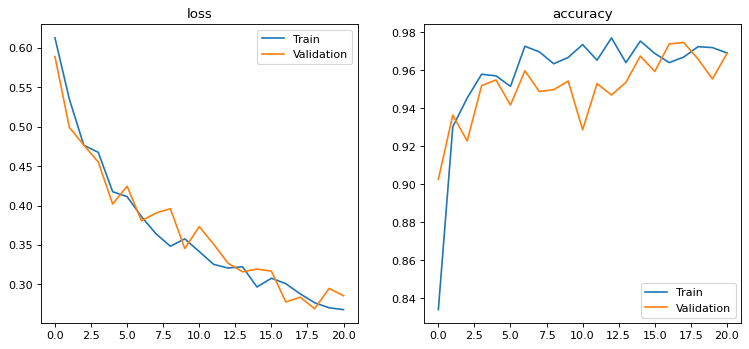

 min val_loss
0.26907260219256085
Epoch 21 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 21, accuracy: 0.9726750300480769, loss: 0.2551703338439648


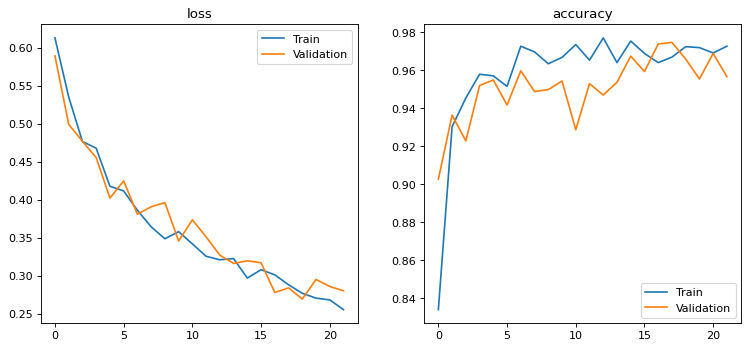

 min val_loss
0.26907260219256085
Epoch 22 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 22, accuracy: 0.9760460486778846, loss: 0.2636801199271129


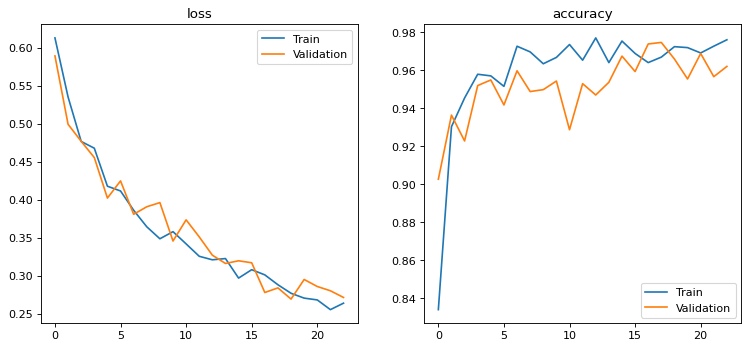

 min val_loss
0.26907260219256085
Epoch 23 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 23, accuracy: 0.9816847581129807, loss: 0.24293936215914214


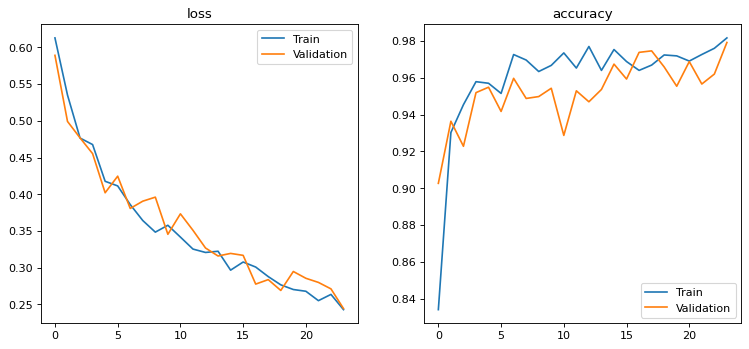

 min val_loss
0.26907260219256085
Epoch 24 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 24, accuracy: 0.9705998347355769, loss: 0.25021070585801053


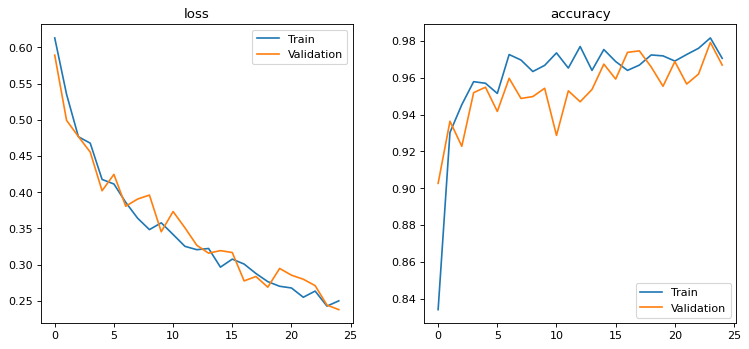

 min val_loss
0.24438861509164175
Epoch 25 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 25, accuracy: 0.9729285606971154, loss: 0.23958877875254705


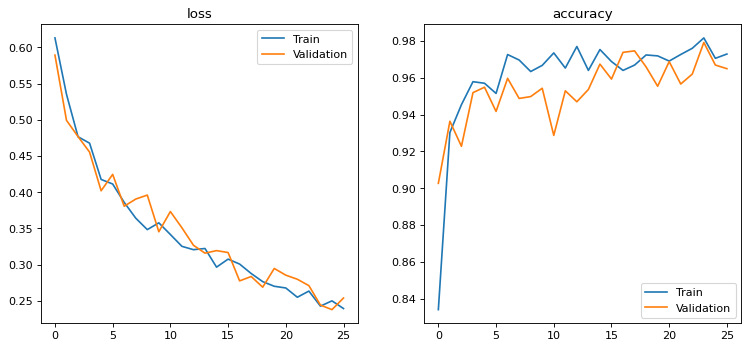

 min val_loss
0.23808318376541138
Epoch 26 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 26, accuracy: 0.9780132587139423, loss: 0.230578940648299


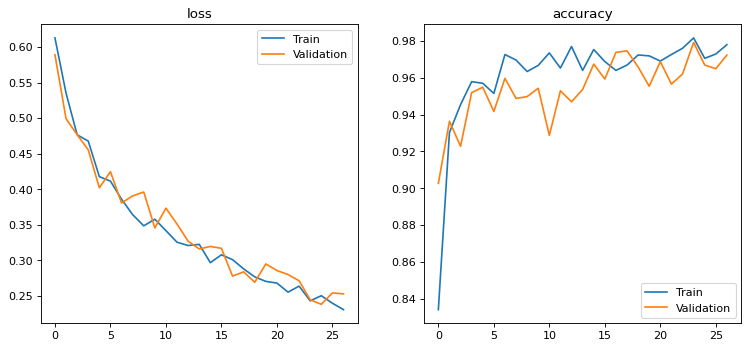

 min val_loss
0.23808318376541138
Epoch 27 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 27, accuracy: 0.9811683067908654, loss: 0.21997843224268693


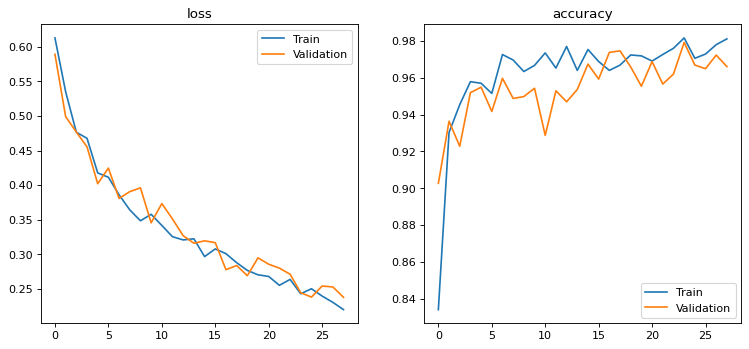

 min val_loss
0.23808318376541138
Epoch 28 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 28, accuracy: 0.9740788386418269, loss: 0.22794144887190598


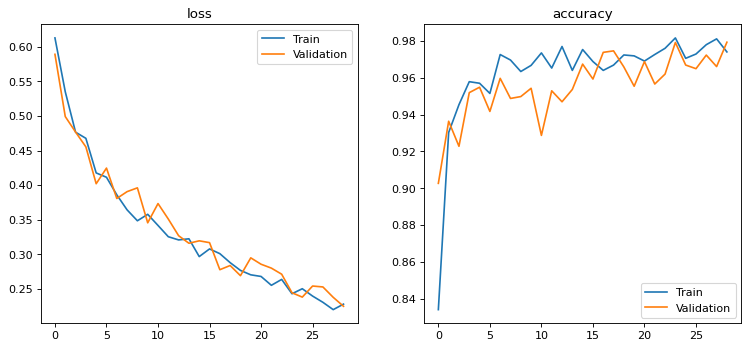

 min val_loss
0.2377935747305552
Epoch 29 / 30
	Batch 0
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
	Batch 8
	Batch 9
	Batch 10
	Batch 11
	Batch 12
epoch: 29, accuracy: 0.9811260516826923, loss: 0.21482150027385125


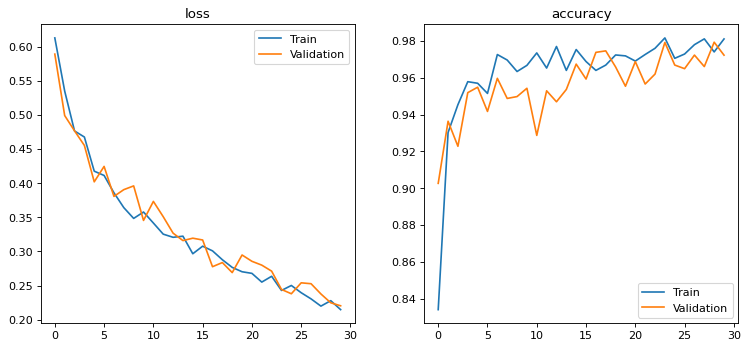

 min val_loss
0.22482875982920328


In [11]:
from math import remainder
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []
min_val_loss = float('inf')

for epoch in range(epochs):
    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables
    #correct = 0
    #overlap = 0 
    #union = 0
    _len = 0
    loss_sum = 0
    accuracy_sum = 0
    count = 0
    
    # Loop over the batches
    for index, (train_batch, mask) in enumerate(train_data_loader):
        print(f'\tBatch {index}')
        
        if device is not None:
            train_batch = train_batch.to(device)
            mask = mask.to(device)

        # Call the model (image to mask)
        prediction = model(train_batch)
        
        # Compute the loss
        
        mask = torch.squeeze(mask.to(torch.float32))
        prediction= torch.squeeze(prediction.to(torch.float32))
        Loss = loss(prediction, mask)

        # Do PyTorch stuff
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
        
        threshold_using = 0.5
        binary = prediction >= threshold_using
        current_accuracy = metrics.accuracy_score(mask.cpu().view(-1).detach().numpy(), binary.cpu().view(-1).detach().numpy()) 
        accuracy_sum = accuracy_sum + current_accuracy
        loss_sum = loss_sum+Loss.data.item()
        count = count+1
    
    
    train_loss = loss_sum/count
    train_accuracy = accuracy_sum/count
    string = "epoch: {}, accuracy: {}, loss: {}".format(epoch, train_accuracy, train_loss)
    print(string)
    val_loss, val_accuray = validate(model, loss, val_data_loader, device)
    
    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_accuracy)
    
    epoch_val_loss.append(val_loss)
    epoch_val_accuracy.append(val_accuray)
    
    if len(epoch_train_loss) > 0:
        plt.figure(figsize=(10, 5), dpi=80)
        plt.subplot(1,2,1)
        plt.title('loss')
        plt.plot(epoch_train_loss)
        plt.plot(epoch_val_loss)
        plt.legend(['Train', 'Validation'], loc='upper right')
        #plt.ylim(0, 0.1)
        plt.subplot(1,2,2)
        plt.title('accuracy')
        plt.plot(epoch_train_accuracy)
        plt.plot(epoch_val_accuracy)
        plt.legend(['Train', 'Validation'], loc='lower right')
        #plt.ylim(0.95, 1)
        plt.tight_layout(pad=3.0)
        plt.show()
    print(' min val_loss')
    #print(val_loss)
    print(min_val_loss)
    if min_val_loss > val_loss: # update the model with best performance
        min_val_loss = val_loss
        best_model = model
        best_epoch = epoch
        
    if remainder(epoch, 10) == 0: # saved the best model every 10 epochs
        model_save_path_best= join('/kaggle/working', 'best_model' + '.pth')
        torch.save(model, model_save_path_best)


# Define the function for evaluation

In [12]:
import skimage.color as color
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, jaccard_score
import cv2
import skimage.io as im

def evaluate(measurement_name, test_label_path, data_path, model_path):

    threshold_using = 0.5
    newsize = (320, 256)

    device = torch.device("cpu")

    model = torch.load(model_path,map_location='cpu')
    model.to(device)
    #model.eval()
    #
    mat_data = io.loadmat(data_path)
    data = np.float32(mat_data["imageArray"])

    imge = torch.from_numpy(data.copy())
    imge = imge.permute(2, 0, 1)
    input = torch.zeros(1, imge.size(0), imge.size(1), imge.size(2))
    input[0] = imge

    # normalization
    eps = 1e-10
    mean_value = torch.mean(input)
    std_value = torch.std(input)
    input = (input - mean_value) / max(eps, std_value)
    #""

    with torch.no_grad():
        output = model(input)
    pre = torch.reshape(output, (imge.size(1), imge.size(2)))
    pre = torch.reshape(pre, (1, imge.size(1), imge.size(2))).float()
    np_image = np.asarray(torch.squeeze(pre))

    binary = np_image > threshold_using  

    np_image[np_image > threshold_using] = 255
    np_image[np_image <= threshold_using] = 0

    test_label_np = im.imread(test_label_path)
    plt.figure(figsize=(10, 5), dpi=80)
    plt.subplot(1,2,1)
    plt.title('predicted mask ')
    im.imshow(np_image)
    plt.subplot(1,2,2)
    plt.title('groundtruth mask')
    im.imshow(test_label_np)
    plt.show()

    ## evaluation
    test_label = torch.from_numpy(test_label_np)
    test_label_1d = (test_label.view(test_label.shape[0]*test_label.shape[1])).type('torch.FloatTensor')
    test_label_1d = test_label_1d/255
    binary_torch = torch.from_numpy(binary.astype(int))

    binary_torch_numpy255 = binary_torch.numpy().astype(np.uint8)*255
    test_label_numpy = test_label.numpy()

    binary_torch_1d = binary_torch.reshape(binary_torch.shape[0]*binary_torch.shape[1])
    accuracy = accuracy_score(test_label_1d, binary_torch_1d)
    recall = recall_score(test_label_1d, binary_torch_1d)
    precision = precision_score(test_label_1d, binary_torch_1d)
    f_score = f1_score(test_label_1d, binary_torch_1d)
    iou = jaccard_score(test_label_1d, binary_torch_1d)

    print("measurement " + measurement_name)
    print(
        "results of 2 class classification:\n"
        "threshold:{:.3f},\n"
        "Accuracy:({:.3f}%),\n "
        "Recall:({:.3f}%),\n"
        "Precision:({:.3f}%),\n "
        "F score: ({:.3f}%)\n"
        "iou: ({:.3f}%)\n".format(
            threshold_using,
            100. * accuracy,
            100. * recall,
            100. * precision,
            100. * f_score,
            100. * iou))

# Run the test


/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


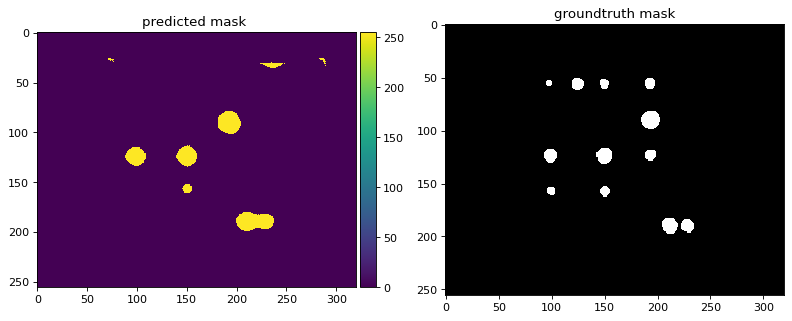

measurement Z_004
results of 2 class classification:
threshold:0.500,
Accuracy:(98.396%),
 Recall:(68.375%),
Precision:(51.432%),
 F score: (58.705%)
iou: (41.548%)



In [13]:
model_folder = '/kaggle/working/'
data_folder = data_splitting_folder
measurement_name = 'Z_004'
test_label_path = join(data_folder, measurement_name+'_mask.png') 
data_path = join(data_folder, measurement_name+'.mat')
model_path = join(model_folder, 'best_model' + '.pth')



evaluate(measurement_name, test_label_path, data_path, model_path)